## Murine bone-marrow derived macrophages

https://data.broadinstitute.org/bbbc/BBBC020/

## Make a torch dataset

In [1]:
from segmentation.datasets import BroadDataset

### Show some images

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
base = '/Users/nicholassofroniew/Documents/BBBC/BBBC020_v1/BBBC020_v1-cells'
train_dataset = BroadDataset(base, 'train')

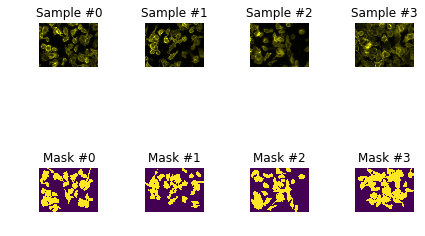

In [4]:
fig = plt.figure()

for i in range(len(train_dataset)):
    img, mask = train_dataset[i]

#    print(i, sample['image'].shape)

    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(img)
    ax = plt.subplot(2, 4, i + 5)
    ax.set_title('Mask #{}'.format(i))
    ax.axis('off')
    plt.imshow(mask)
    if i == 3:
        plt.show()
        break

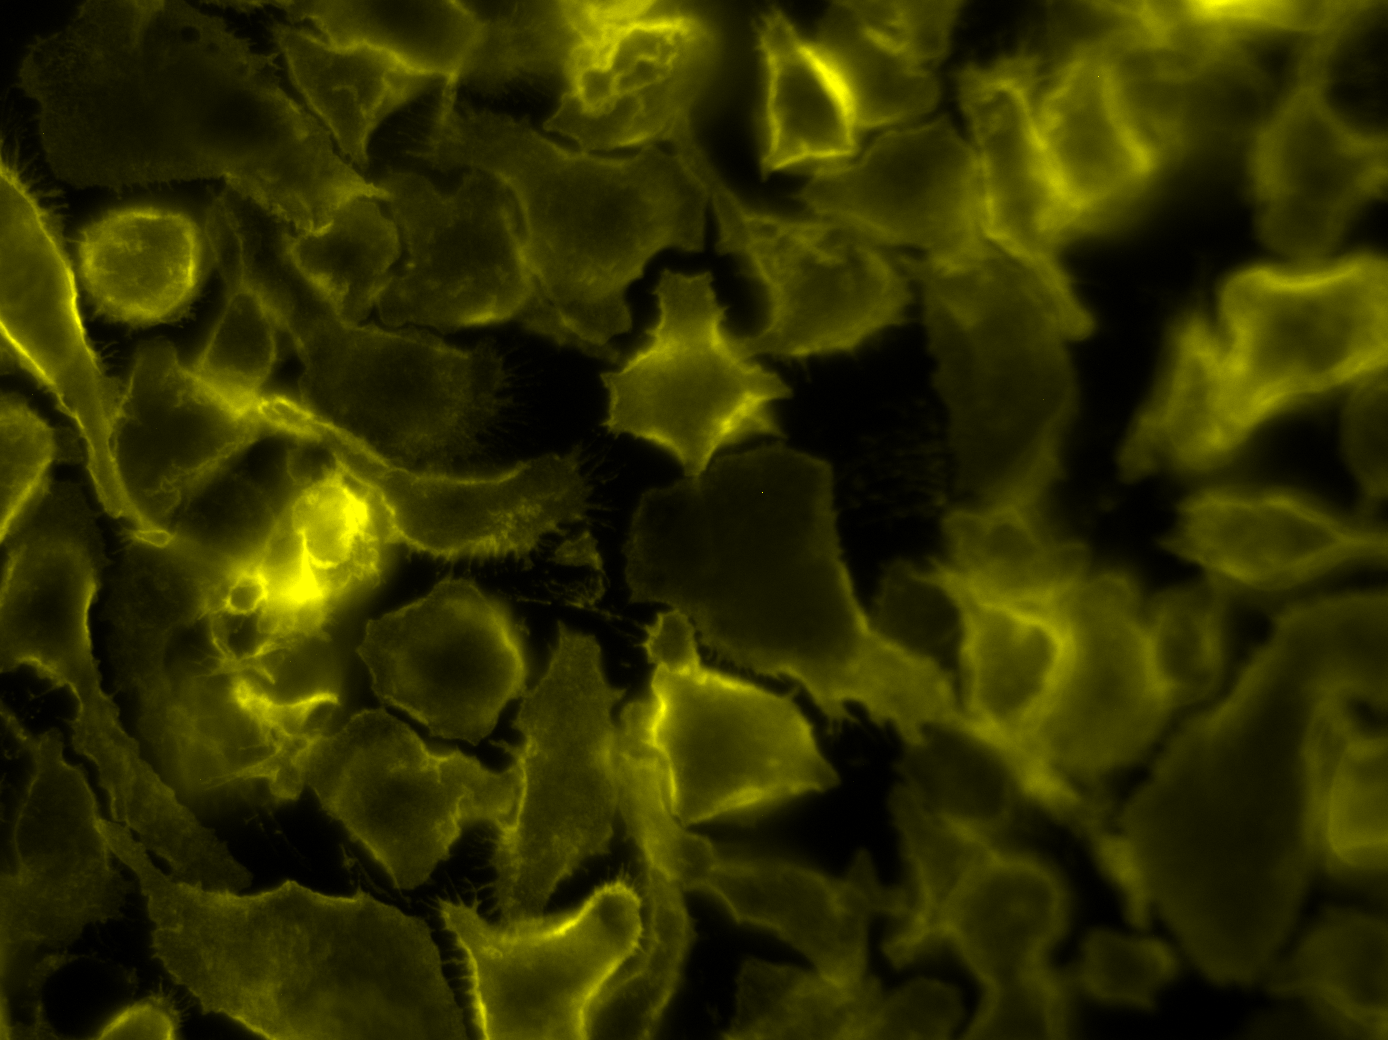

In [5]:
img

## Define transforms

In [6]:
from skimage.transform import estimate_transform, warp
from numpy import linspace, meshgrid, dstack, vstack, sin
from numpy.random import normal
import numbers

In [7]:
class RandomWarp(object):
    def __init__(self, controlpoints, scale):
        if isinstance(controlpoints, numbers.Number):
            self.controlpoints = (int(controlpoints), int(controlpoints))
        else:
            self.controlpoints = controlpoints
        self.scale = scale

    def __call__(self, img, mask):

        cols = img.size[1]
        rows = img.size[0]
    
        src_cols = linspace(0, cols, self.controlpoints[1])
        src_rows = linspace(0, rows, self.controlpoints[0])
        src_rows, src_cols = meshgrid(src_rows, src_cols)
        src = dstack([src_cols.flat, src_rows.flat])[0]

        dst_rows = src[:, 1] + normal(scale=self.scale, size=src[:, 1].shape)
        dst_cols = src[:, 0] + normal(scale=self.scale, size=src[:, 1].shape)
        dst = vstack([dst_cols, dst_rows]).T

        tform = estimate_transform('piecewise-affine', src, dst)

        return warp(img, tform, output_shape=img.size), warp(mask, tform, output_shape=mask.size)

In [8]:
from torchvision import transforms
import segmentation.transforms as extended_transforms

joint_transform = extended_transforms.Compose([
    extended_transforms.RandomHorizontallyFlip(),
    extended_transforms.RandomVerticallyFlip(),
    extended_transforms.CenterCrop(512),
#    extended_transforms.RandomRotate(45),
    RandomWarp(3, 10)])

input_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
target_transform = extended_transforms.MaskToTensor()

In [9]:
train_dataset = BroadDataset(base, 'train', joint_transform=joint_transform)

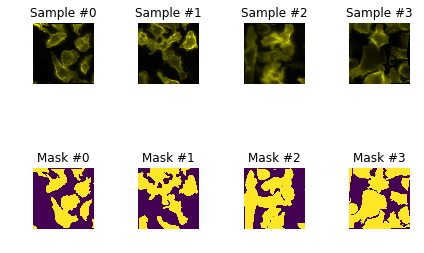

In [10]:
fig = plt.figure()

for i in range(len(train_dataset)):
    img, mask = train_dataset[i]

#    print(i, sample['image'].shape)

    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(img)
    ax = plt.subplot(2, 4, i + 5)
    ax.set_title('Mask #{}'.format(i))
    ax.axis('off')
    plt.imshow(mask)
    if i == 3:
        plt.show()
        break

In [11]:
train_dataset = BroadDataset(base, 'train', joint_transform=joint_transform, input_transform=input_transform, target_transform=target_transform)

In [12]:
from torch.utils.data import DataLoader
trainloader = DataLoader(train_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)

## Load network

In [13]:
from segmentation.model import UNet

In [38]:
net = UNet(1)

In [39]:
net.train()

UNet (
  (enc1): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU (inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU (inplace)
      (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (enc2): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU (inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU (inplace)
      (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (enc3): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
     

### Define loss function and optimizer

In [40]:
from segmentation.utilities import mIoULoss, CrossEntropyLoss2d, BCELoss2d

In [17]:
from torch import nn
criterion = mIoULoss(size_average=False)
#criterion = nn.NLLLoss2d()
#criterion = nn.BCEWithLogitsLoss()

In [18]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Pass data throuhg network

In [19]:
import torch.nn.functional as F
from torch.autograd import Variable
img, mask = train_dataset[0]
tmp = Variable(mask).unsqueeze(0)
foo = net(Variable(img).unsqueeze(0)).squeeze(0)

In [20]:
print(tmp)
print(foo)
#print(bar)

Variable containing:
( 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   1   1   1  ...    0   0   0
   1   1   1  ...    0   0   0
   1   1   1  ...    0   0   0
[torch.LongTensor of size 1x512x512]

Variable containing:
( 0 ,.,.) = 
  1.0430e+00  1.0299e+00  9.9098e-01  ...  -1.3690e+00 -1.6127e+00 -1.1594e+00
  1.1059e+00  9.5195e-01  8.1493e-01  ...   6.6182e-02 -3.3499e-01 -3.4999e-01
  1.0169e+00  8.4566e-01  6.9724e-01  ...   4.6459e-01  5.3320e-03 -7.5968e-02
                 ...                   ⋱                   ...                
 -1.6140e+00 -1.5164e-01 -2.1863e-01  ...  -1.5903e-01 -1.1674e-01 -6.4796e-02
 -2.1061e+00 -5.8587e-01 -5.4759e-01  ...  -1.6157e-01 -1.3459e-01 -9.5443e-02
 -3.4548e+00 -1.6340e+00 -1.4329e+00  ...  -2.7494e-01 -2.8690e-01 -2.0268e-01
[torch.FloatTensor of size 1x512x512]



In [21]:
loss = criterion(foo, tmp)
print(loss)

Variable containing:
 69.3980
[torch.FloatTensor of size 1]



In [22]:
loss.backward()

### Train network

In [23]:
from segmentation.main import train

In [24]:
for epoch in range(2):  # loop over the dataset multiple times
    train(trainloader, net, criterion, optimizer, epoch)
print('Finished Training')

Finished Training


### Load and save model

In [25]:
import torch
from os.path import join
snapshot_name = 'UNet_1'

In [26]:
torch.save(net.state_dict(), join(base, 'models', snapshot_name + '.pth'))
torch.save(optimizer.state_dict(), join(base, 'models', 'opt_' + snapshot_name + '.pth'))

In [34]:
net.load_state_dict(torch.load(join(base, 'models', snapshot_name + '.pth'), map_location={'cuda:0': 'cpu'}))
#optimizer.load_state_dict(torch.load(join(base, 'models', 'opt_' + snapshot_name + '.pth'), map_location={'cuda:0': 'cpu'}))

### Look at perforance on validation set

In [27]:
val_dataset = BroadDataset(base, 'val', joint_transform=joint_transform, input_transform=input_transform, target_transform=target_transform)

In [28]:
from torch.autograd import Variable
img, mask = val_dataset[0]
output = net(Variable(img).unsqueeze(0))

In [29]:
prediction = F.sigmoid(output)

In [35]:
img.max()

-0.9921568632125854

In [31]:
#prediction = output.data.max(1)[1].squeeze_(1).squeeze_(0) #.cpu().numpy() #max(1)[1] is equiv to argmax
#prediction = F.log_softmax(output)
#prediction = output

In [32]:
prediction.data.squeeze(1).squeeze(0).numpy().shape

(512, 512)

[ 13.19310093]


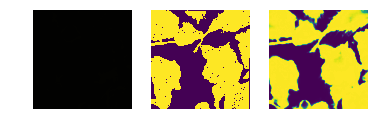

In [34]:
ax = plt.subplot(1,3,1);
plt.imshow(img.numpy().transpose(1,2,0))
ax.axis('off');
ax = plt.subplot(1,3,2);
plt.imshow(mask.numpy())
ax.axis('off');
ax = plt.subplot(1,3,3);
plt.imshow(prediction.squeeze(0).squeeze(0).data.numpy())
ax.axis('off');
loss = criterion(output, Variable(mask).unsqueeze(0))
print(loss.data.numpy())

In [36]:
valloader = DataLoader(val_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)

In [37]:
correct = 0
total = 0
for data in valloader:
    images, labels = data
    outputs = net(Variable(images))
    loss = criterion(output, Variable(labels)).data.numpy()[0]

    print(loss)
    total += labels.size(0)
    correct += loss

print('Mean Intersection Over Union: %.2f %%' % (
    correct / total))

68.895
22.1577
Mean Intersection Over Union: 45.53 %


In [143]:
def mIoU(output, target):
    intersection = output*target
    union = (output + target)>0
    return intersection.sum()/union.sum()

In [ ]:
correct = 0
total = 0
for data in valloader:
    images, labels = data
    outputs = net(Variable(images))
    predicted = output.data.max(1)[1]
    m = mIoU(predicted, labels)
    print(m*100)
    total += labels.size(0)
    correct += m

print('Mean Intersection Over Union: %.2f %%' % (
    100 * correct / total))